# AIS Port Classification notebook

This notebook is a walktrough of the AIS Marinetime Project by group 135. In this project, we have focused on Port Classification given time series data. 

The notebook consits of the following contents:
- [Introduction](#introduction)
- [Setup](#setup) 
- [Data](#data) 
    - [Data source & preparation](#data-source--preparation) 
    - [Descriptive statistics & Data Visualization](#descriptive-statistics--data-visualization) 
    - [Feature Engineering](#feature-engineering) 

- [Training](#training-model)

# Introduction 

In this section, we will introduce the goal and methods in this project. We will present the different models and techniques used for port classification using AIS data. 

## The Goal of the Project 
The goal of this project is to build a model that can accurately classify ports based on AIS data. 
To achive this, we will have used 3 deep learning models and one simple machine learning model as a baseline. The models used are:  
1. LSTM - Long Short-Term Memory network 
2. Transformer
3. LSTM-Transformer Hybrid Model
4. "TO DO " (baseline) 


For each model, the output is from a feed forward neural network with can be toughts of as logits. 

We use the cross-entropy loss function to train the models, as it is well suited for multi-class classification problems. 



# Setup

Before running this notebook, make sure to install the required dependencies listed in the `pyproject.toml` file and have access to the dataset used in this project.

This project uses `uv` as the Python package manager. All dependencies are defined in `pyproject.toml`.

Run the following commands to set up your environment:

```bash
# Install all dependencies from pyproject.toml
uv sync

# Install the project in editable mode (to import from src/)
uv pip install -e .
```

The cleaned dataset used in this project can be found here: [https://drive.google.com/drive/folders/1o17rqpOwHRdrgkoRS8rd5g62xi9nsTuk?hl=da] 

The folder is called "processed_data" and should be zipped and placed in the data directory of this project.

Otherwise, you can down the data in the next cell. 



In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
from Dataloader import Dataloader 
import numpy as np 
import torch  
from RNN import clean_data, setup_and_train, collate_fn
from utils import MaritimeDataset, StatEvalAIS, plot_trajectory_on_map, download
import os
import zipfile 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import mlflow 
import gc

In [2]:
config = {

    "TRAIN_OWN_MODEL": False,

    "CLEAN_DATA": False, #Set to True if data needs to be cleaned 


    "DOWNLOAD_DATA_FROM_SOURCE": False, #Set to True if data needs to be downloaded from source
    "Experiment_Name": "AIS-Classifier-Experiment",


    ##Paths for saving and loading models and data
    "LOAD_CLEANED_DATA_PATH": "data/cleanded_data.parquet", 
    
    "DATA_PATH": "data/processed_data", 
}


#By chaning the hyperparams, it should be noted that no Pretrained models exist
hyperparams = {
        "general": {
        "batch_size": 32,
        "num_epochs": 30,
        "learning_rate": 0.0001,
        },

        #Model specific hyperparameters
        "LSTM": {
        "lstm_hidden_size": 1024,
        "lstm_num_layers": 2,
        "dropout": 0.3,
        "batch_first": True
        }, 

        "LSTM_Transformer": {
        "hidden_size": 1024,
        "num_lstm_layers": 2,
        "num_heads": 4,
        "num_transformer_layers": 3,
        "dropout": 0.3,
        "batch_first": True
        }
    }


#Setting seed for reproducibility 
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed_all(42)  



# Data

Downloading data from source:

In [3]:
if (config["DOWNLOAD_DATA_FROM_SOURCE"]):    
    data_links = {"Jan": "http://aisdata.ais.dk/2023/aisdk-2023-01.zip",
                  "Feb": "http://aisdata.ais.dk/2023/aisdk-2023-02.zip",
                  "Mar": "http://aisdata.ais.dk/2023/aisdk-2023-03.zip",
                  "Apr": "http://aisdata.ais.dk/2023/aisdk-2023-04.zip",
                  "May": "http://aisdata.ais.dk/2023/aisdk-2023-05.zip",
                  "Jun": "http://aisdata.ais.dk/2023/aisdk-2023-06.zip",
                  "Jul": "http://aisdata.ais.dk/2023/aisdk-2023-07.zip",
                  "Aug": "http://aisdata.ais.dk/2023/aisdk-2023-08.zip",
                  "Sep": "http://aisdata.ais.dk/2023/aisdk-2023-09.zip",
                  "Oct": "http://aisdata.ais.dk/2023/aisdk-2023-10.zip",
                  "Nov": "http://aisdata.ais.dk/2023/aisdk-2023-11.zip",
                  "Dec": "http://aisdata.ais.dk/2023/aisdk-2023-12.zip"
                 }

    data_dir = "data/unprocessed"
    end_dir = "data/processed"



    os.makedirs(data_dir, exist_ok=True)
    os.makedirs(end_dir, exist_ok=True)

    for month, link in data_links.items():
        filename = link.split("/")[-1]
        filepath = os.path.join(data_dir, filename)

        # Extract month number from filename
        month_num = filename.split("-")[2].replace(".zip", "")

        # Check if all parquet files for this month already exist
        # Quick check: if folder has files matching this month pattern
        existing_parquets = [f for f in os.listdir(end_dir) if f.startswith(f"aisdk-2023-{month_num}-") and f.endswith('.parquet')]

        # A month should have 28-31 parquet files
        if len(existing_parquets) >= 28:
            print(f"⏭️  Skipping month {month}: {len(existing_parquets)} parquet files already exist")
            continue

        # Download if needed
        if os.path.exists(filepath):
            print(f"⏭️  Skipping download for month {month}: {filepath} (already exists)")
        else:
            print(f"Downloading data for {month}...")
            download(link, filepath)
            print(f"Downloaded data for {month}")

        # Open ZIP once and process all CSV files
        with zipfile.ZipFile(filepath, 'r') as zip_ref:
            csv_files = [f for f in zip_ref.namelist() if f.endswith('.csv')]
            print(f"Found {len(csv_files)} CSV files in {filename}")

            for csv_filename in csv_files:
                output_filename = csv_filename.replace('.csv', '.parquet')
                output_path = os.path.join(end_dir, output_filename)

                if os.path.exists(output_path):
                    print(f"⏭️  Skipping {output_filename} (already exists)")
                    continue

                print(f"📝 Processing: {csv_filename}")

                data = Dataloader(
                    file_path="",
                    out_path=output_path,
                    zip_path=filepath,
                    csv_internal_path=csv_filename
                )
                data.clean_data()

        print(f"✅ Processed {month}")

        # Remove ZIP after processing 
        os.remove(filepath)
        print(f"🗑️  Removed {filename}")

    print("🎉 All data processed")


## Data source & Preparation 




All the data is being prerocessed and cleaned in the prepare_data.ipynb notebook.

We do the following steps in the data preparation:
1. Download 2023 raw data from [AIS data source](http://aisdata.ais.dk/)
2. We only keep the column that we deem are relevant for our project i.e 
    - MMSI
    - SOG 
    - COG
    - Longitude
    - Latitude
    - Timestamp 
    - Ship type 
    - Type of mobile  
    - Length 
    - Width 
    - Destination 

3. We filter the following data points: 
    - data points not in the Danish waters. 
    - data points which are classfied as "Ship type A" and then remove all other ship types. (Type of mobile is redundant after this step and removed).  
    - 1 <= SOG <= 50 knots 
    - Sequences below 250 data points are removed. 
    - data with non-valid port codes are removed (/data_port_locodes.csv are used a source of truth)
    - Filter anomalities where the contains jump in data points that are not realistic (based on SOG and distance between points). 


4. We do the following transformations:
    - Label the data points for each date into segments
    - Datapoints are concated based on segments such that each sequence of a ship can stretch over multiple days. 
    - downsampling such that there is at least 10 seconds between each data point (if two points are closer than 10 seconds, we remove the first point). 




In [4]:
dataloader = Dataloader(out_path=config["DATA_PATH"])

if (config["CLEAN_DATA"]):
    path = config["DATA_PATH"]
    df = dataloader.load_data()  # load all files in the processed_data folder
    #Same cleaning as in RNN 
    df_clean = clean_data(df) 
    df_clean.to_parquet(config["LOAD_CLEANED_DATA_PATH"], index=False)  

else: 
    df_clean = pd.read_parquet(config["LOAD_CLEANED_DATA_PATH"]) 
    

In [5]:
df_clean

,Timestamp,Latitude,Longitude,SOG,COG,Ship type,Width,Length,Destination,MMSI,Date,Segment,Port
0,2023-06-03 14:29:55,53.580400,5.572260,3.703997,71.0,Cargo,13.0,88.0,DEHAM,205103000,2023-06-03,0,no_port
1,2023-06-03 14:30:15,53.580700,5.573400,3.755441,70.3,Cargo,13.0,88.0,DEHAM,205103000,2023-06-03,0,no_port
2,2023-06-03 14:30:25,53.580800,5.573950,3.755441,71.6,Cargo,13.0,88.0,DEHAM,205103000,2023-06-03,0,no_port
3,2023-06-03 14:30:43,53.581000,5.575030,3.755441,71.1,Cargo,13.0,88.0,DEHAM,205103000,2023-06-03,0,no_port
4,2023-06-03 14:31:06,53.581200,5.576180,3.755441,71.4,Cargo,13.0,88.0,DEHAM,205103000,2023-06-03,0,no_port
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30169288,2023-10-03 02:25:01,54.763653,13.340687,7.202216,90.0,Tanker,28.0,185.0,PLGDN,664296000,2023-10-03,1,no_port
30169289,2023-10-03 02:25:13,54.763650,13.342130,7.150772,91.0,Tanker,28.0,185.0,PLGDN,664296000,2023-10-03,1,no_port
30169290,2023-10-03 02:26:01,54.763653,13.347352,7.150772,91.0,Tanker,28.0,185.0,PLGDN,664296000,2023-10-03,1,no_port
30169291,2023-10-03 02:26:25,54.763655,13.350132,7.202216,90.0,Tanker,28.0,185.0,PLGDN,664296000,2023-10-03,1,no_port


## Descriptive statistics & Data Visualization

First we check how the distribution of the different ports are in the cleaned dataset. 

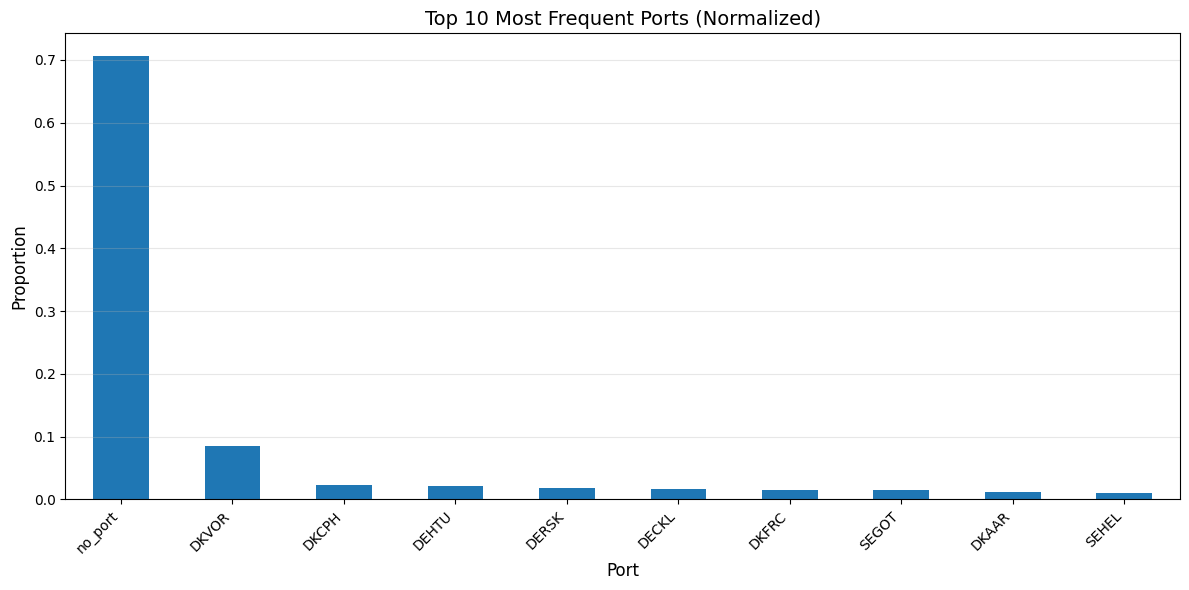

In [6]:
ports = df_clean['Port'] 
ports_norm = ports.value_counts(normalize=True)  # Count occurrences of each port

# Plot top 10 ports as bar chart
top_10 = ports_norm.head(10)
plt.figure(figsize=(12, 6))
top_10.plot(kind='bar')
plt.xlabel('Port', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.title('Top 10 Most Frequent Ports (Normalized)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

Because we see that there is a lot of inbalance between the groups, we will need to balance this out succh that our model doesnt just predict the "no_port" class. 

To solve this problem, we will introduce class weights. We use skilearn's `compute_class_weight` function to calculate the class weights based on the frequency of each class in the training data. 

In [7]:
#plot_trajectory_on_map(df_clean, percentage_of_vessels=0.1)

To check if seasonality plays a role in the data, we plot the weekly observations for each port type

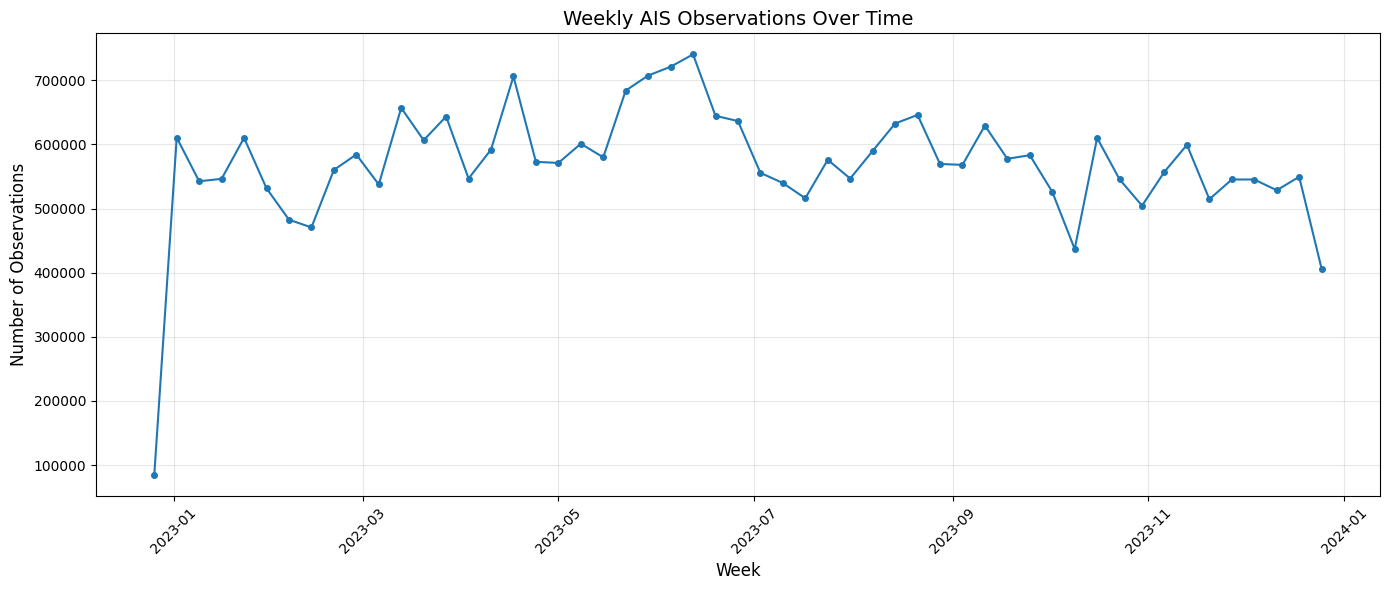

Total weeks: 53
Total observations: 30,169,293
Average observations per week: 569232
Min observations in a week: 84,544
Max observations in a week: 740,347


In [8]:
def plot_weekly_observations(df, timestamp_col="Timestamp"):
    df_copy = df.copy()
    df_copy[timestamp_col] = pd.to_datetime(df_copy[timestamp_col])
    

    df_copy['YearWeek'] = df_copy[timestamp_col].dt.to_period('W')
    weekly_counts = df_copy['YearWeek'].value_counts().sort_index()
    
    weekly_counts.index = weekly_counts.index.to_timestamp()
    
    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(weekly_counts.index, weekly_counts.values, marker='o', linewidth=1.5, markersize=4)
    plt.xlabel('Week', fontsize=12)
    plt.ylabel('Number of Observations', fontsize=12)
    plt.title('Weekly AIS Observations Over Time', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Total weeks: {len(weekly_counts)}")
    print(f"Total observations: {weekly_counts.sum():,}")
    print(f"Average observations per week: {weekly_counts.mean():.0f}")
    print(f"Min observations in a week: {weekly_counts.min():,}")
    print(f"Max observations in a week: {weekly_counts.max():,}")
    
    return weekly_counts


weekly_obs = plot_weekly_observations(df_clean) 

It looks like there is some seasonality in the data, with peaks in the summer months and troughs in the winter months. To invistiage this further and if it have a impact on our ports, we plot the ports observations over time. 

Plotting weekly observations for ship type: no_port


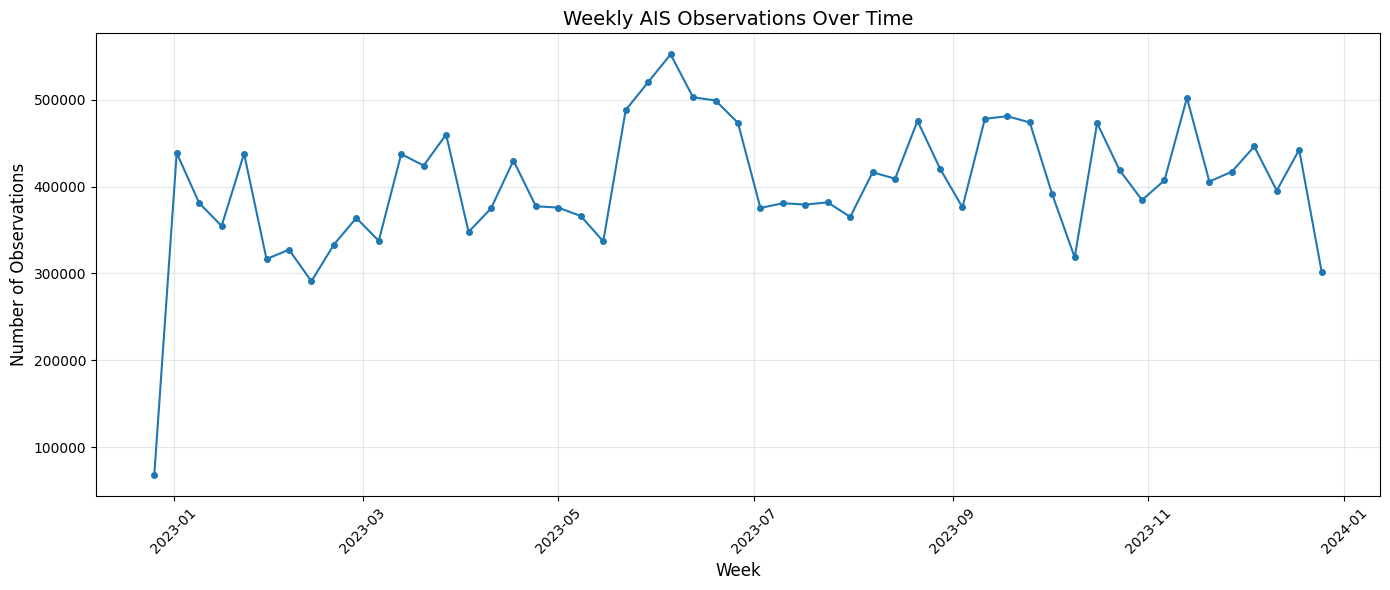

Total weeks: 53
Total observations: 21,332,578
Average observations per week: 402501
Min observations in a week: 67,820
Max observations in a week: 552,228
Plotting weekly observations for ship type: DKVOR


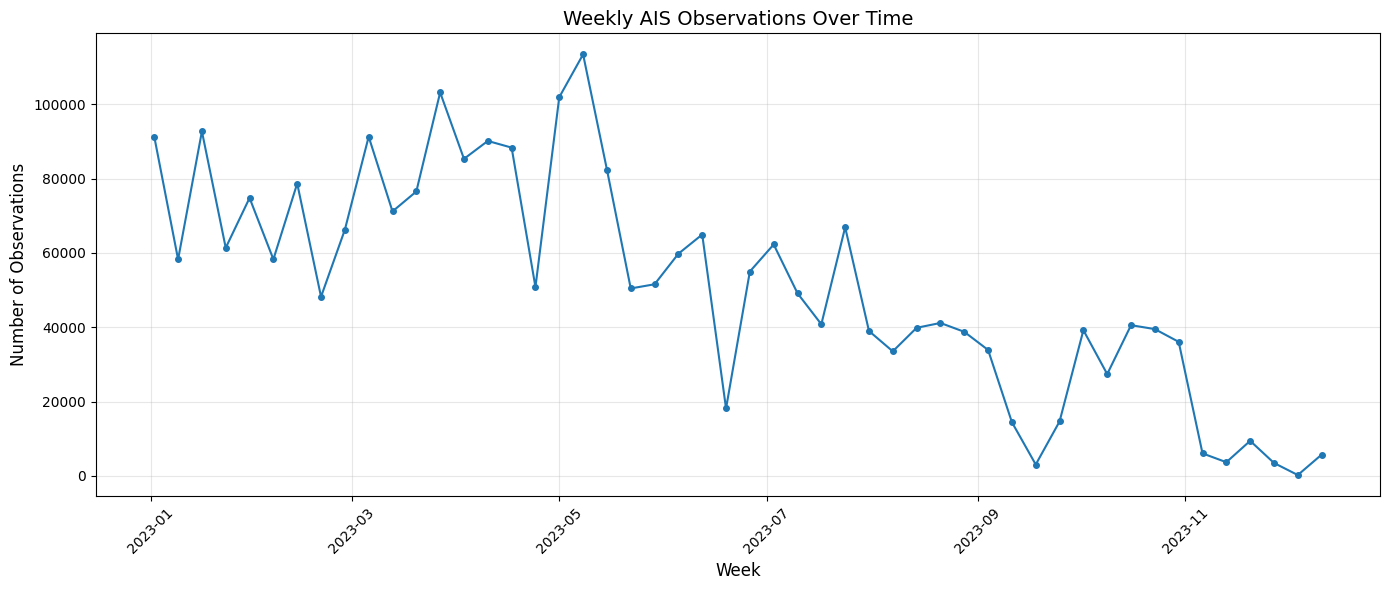

Total weeks: 50
Total observations: 2,573,051
Average observations per week: 51461
Min observations in a week: 210
Max observations in a week: 113,456
Plotting weekly observations for ship type: DKCPH


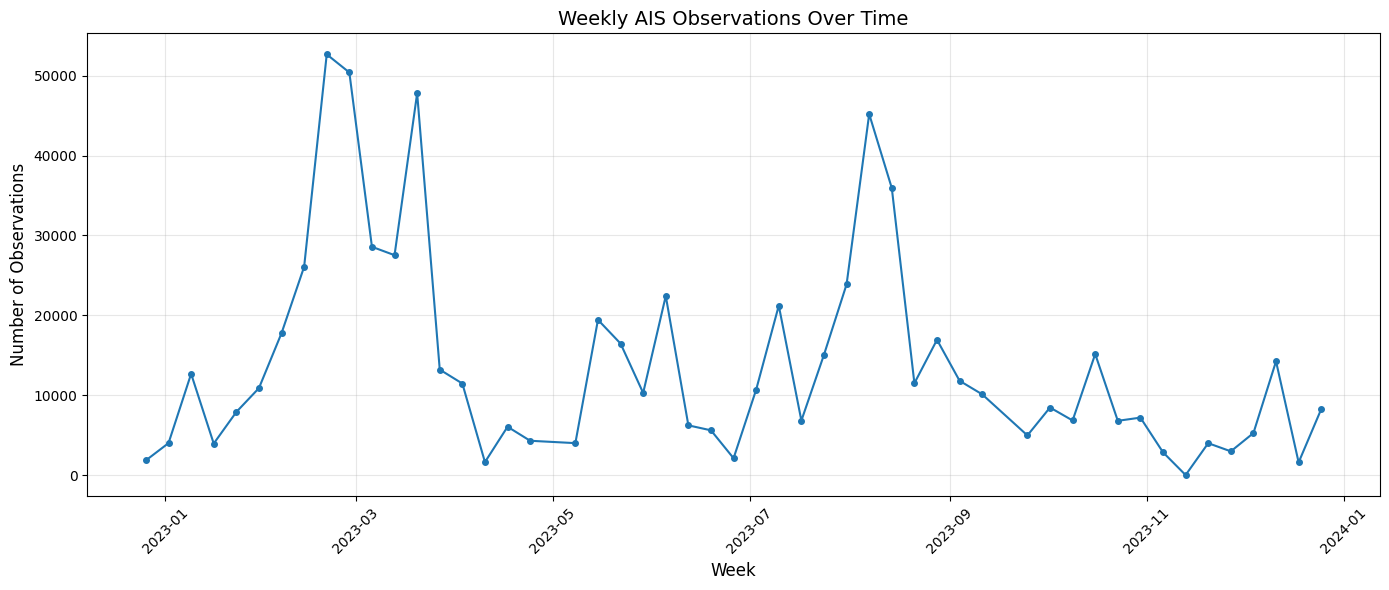

Total weeks: 51
Total observations: 713,325
Average observations per week: 13987
Min observations in a week: 15
Max observations in a week: 52,667
Plotting weekly observations for ship type: DEHTU


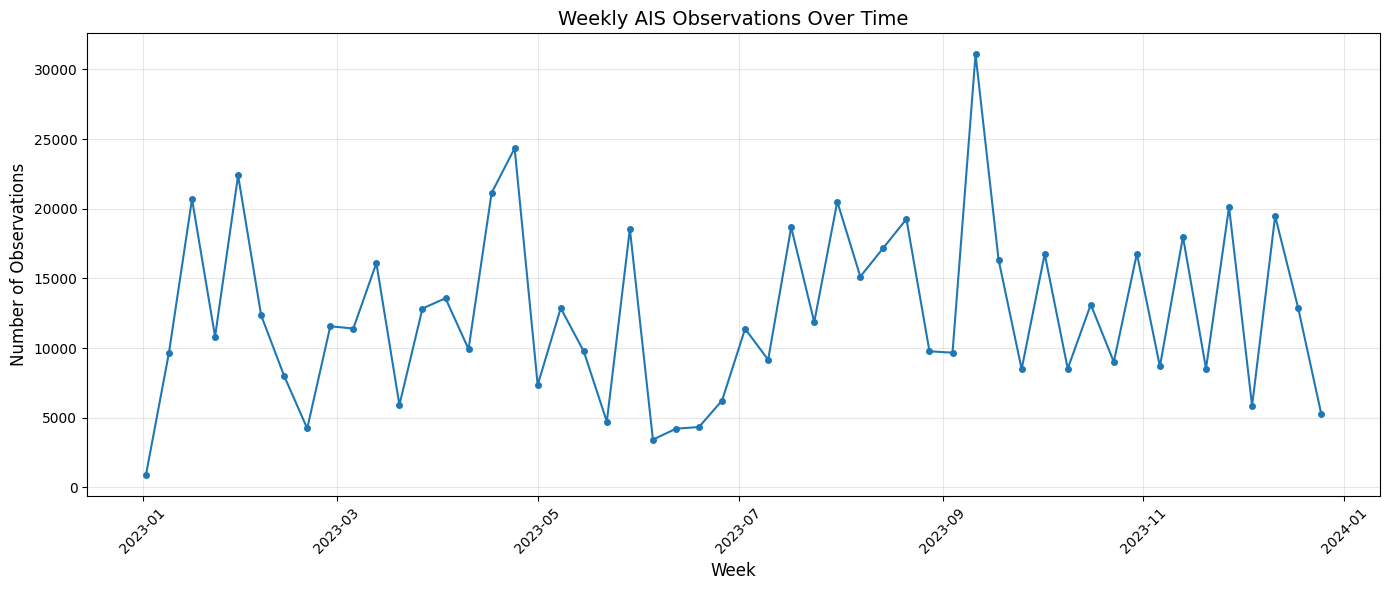

Total weeks: 52
Total observations: 648,746
Average observations per week: 12476
Min observations in a week: 886
Max observations in a week: 31,080
Plotting weekly observations for ship type: DERSK


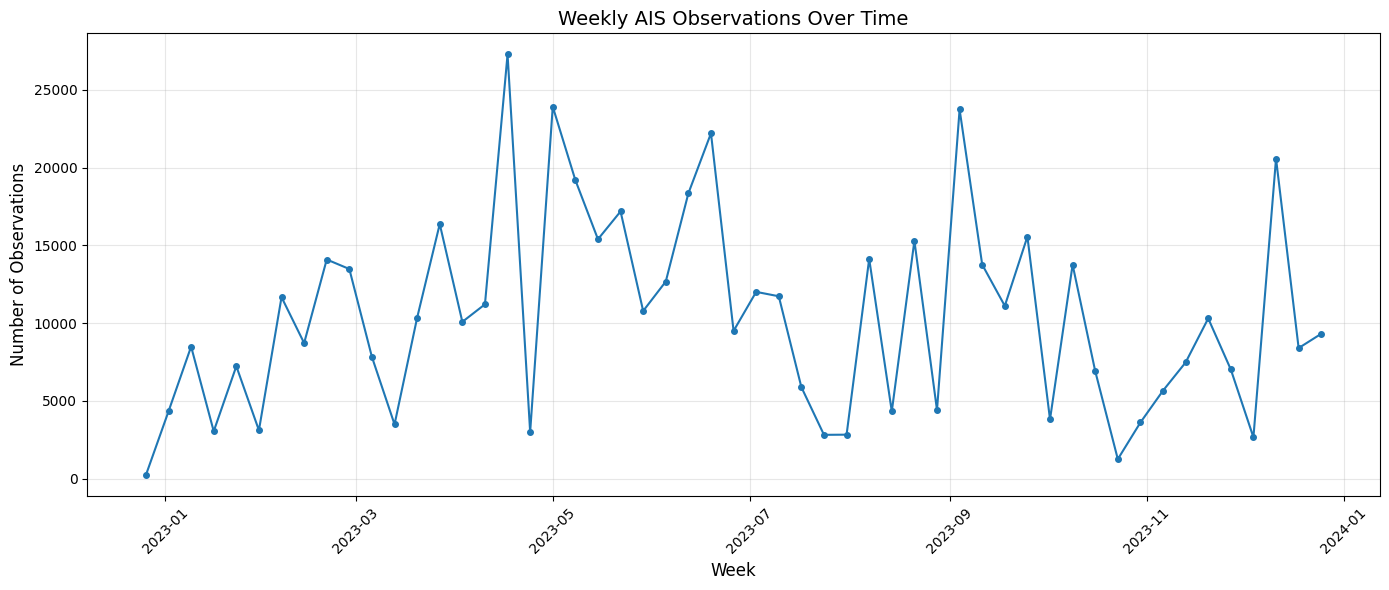

Total weeks: 53
Total observations: 551,389
Average observations per week: 10404
Min observations in a week: 233
Max observations in a week: 27,272
Plotting weekly observations for ship type: DECKL


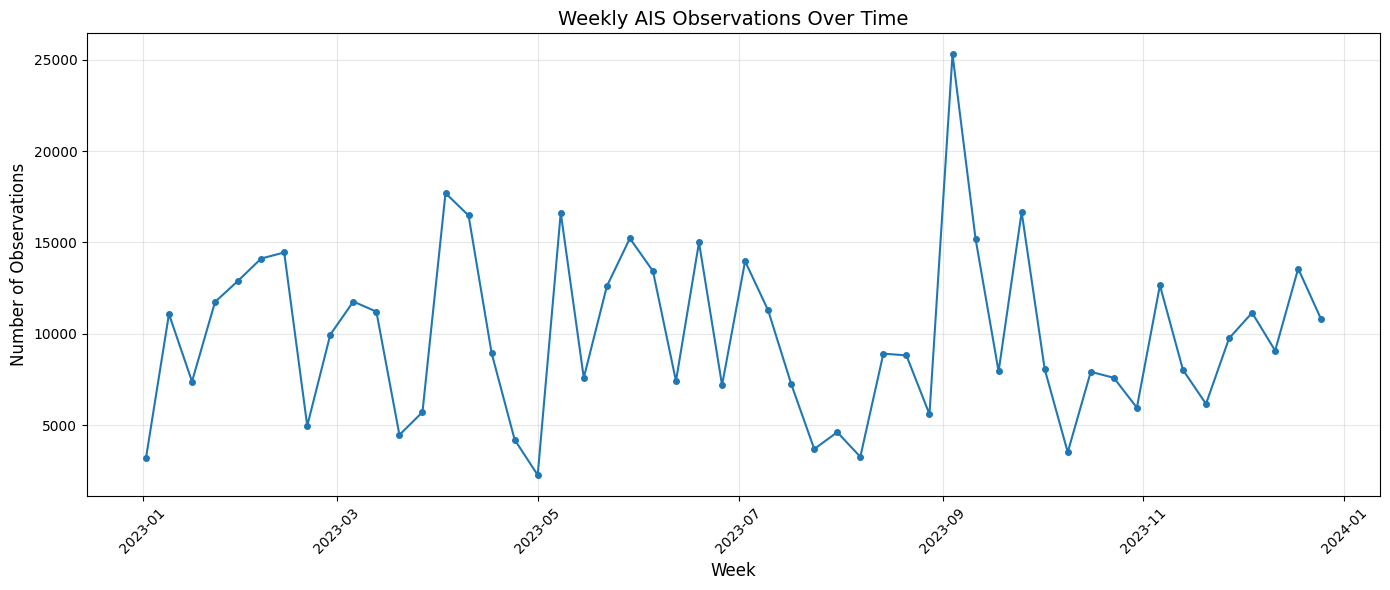

Total weeks: 52
Total observations: 514,725
Average observations per week: 9899
Min observations in a week: 2,284
Max observations in a week: 25,286
Plotting weekly observations for ship type: DKFRC


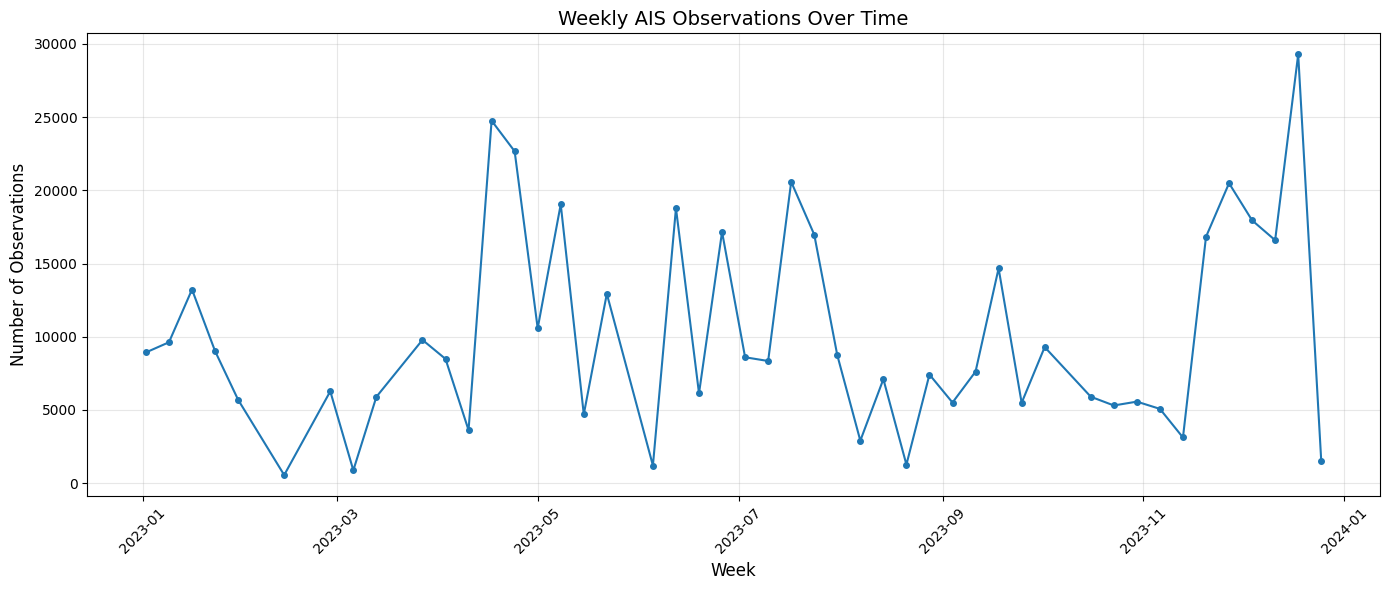

Total weeks: 47
Total observations: 472,072
Average observations per week: 10044
Min observations in a week: 555
Max observations in a week: 29,284
Plotting weekly observations for ship type: SEGOT


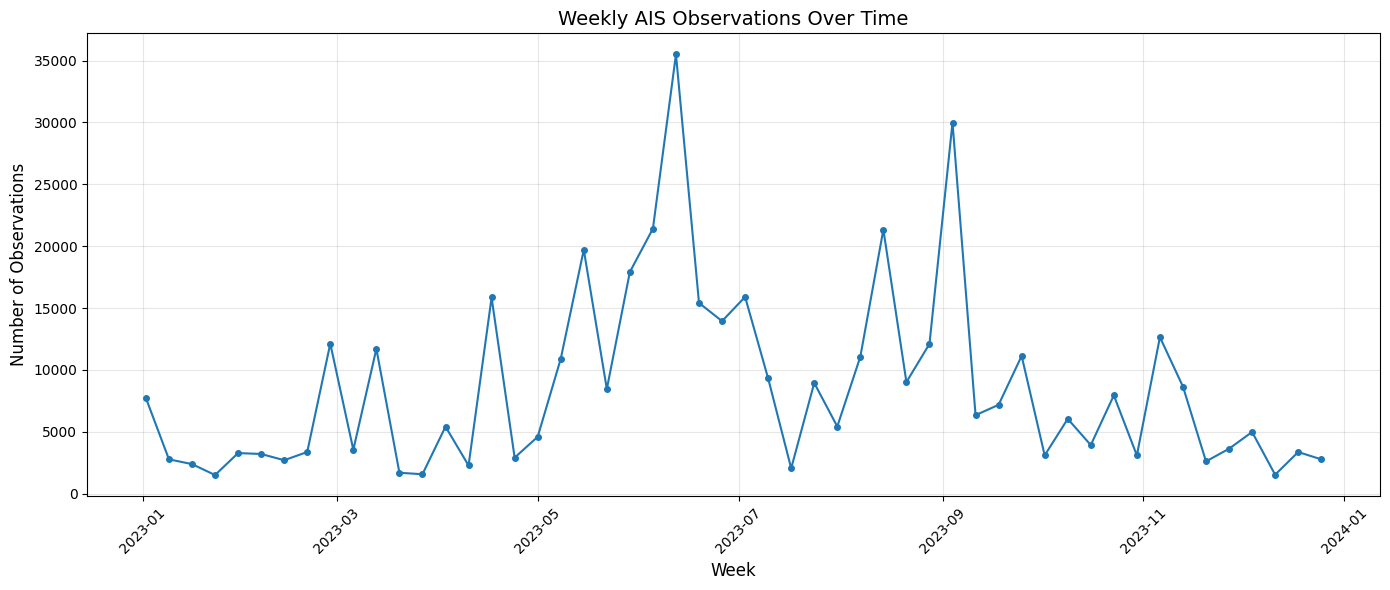

Total weeks: 52
Total observations: 446,189
Average observations per week: 8581
Min observations in a week: 1,511
Max observations in a week: 35,496
Plotting weekly observations for ship type: DKAAR


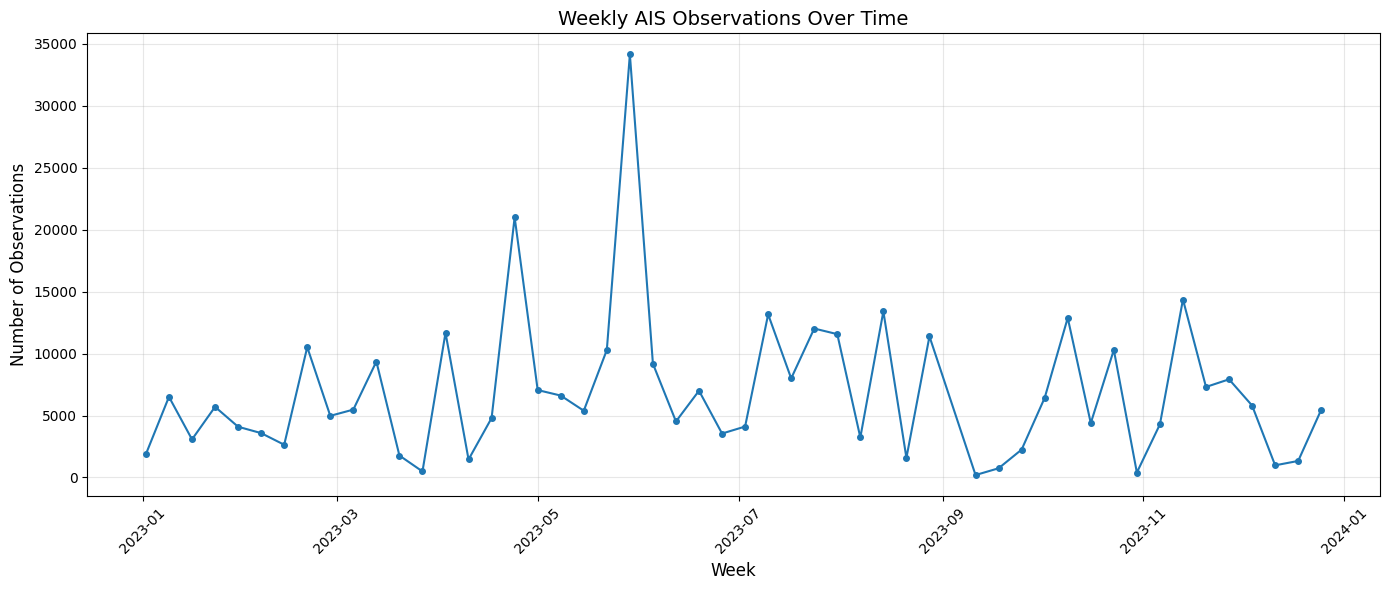

Total weeks: 51
Total observations: 350,295
Average observations per week: 6869
Min observations in a week: 195
Max observations in a week: 34,159
Plotting weekly observations for ship type: SEHEL


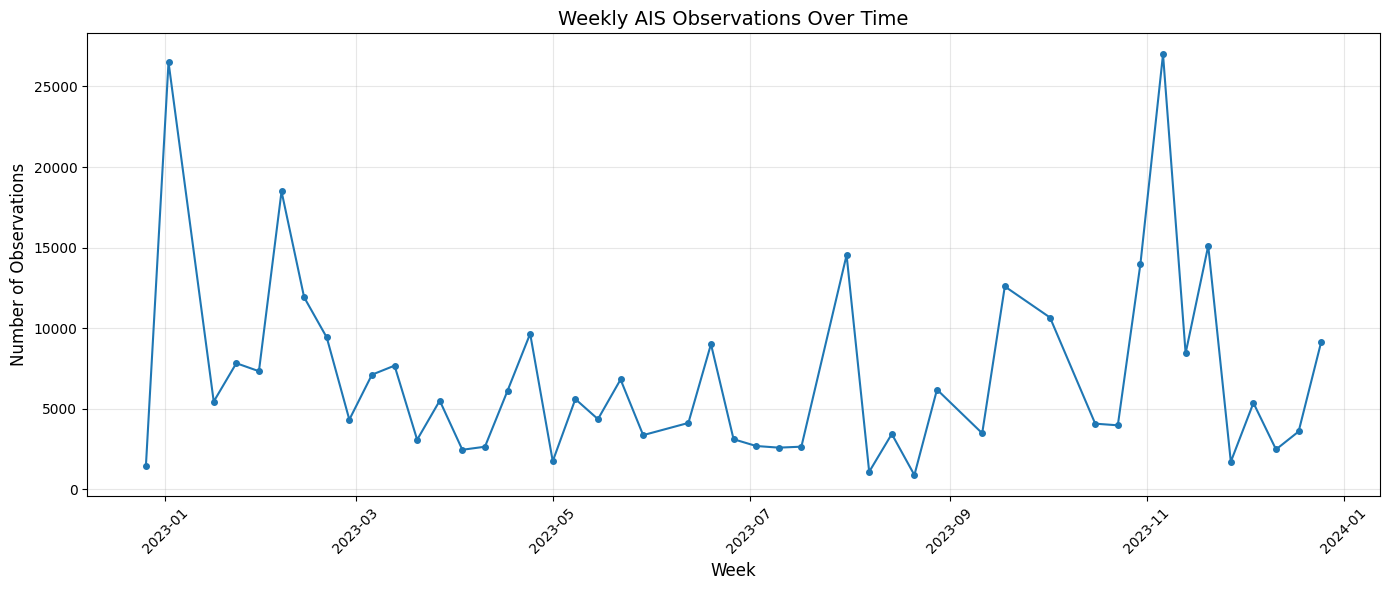

Total weeks: 47
Total observations: 330,908
Average observations per week: 7041
Min observations in a week: 891
Max observations in a week: 26,991


In [9]:
for port_type in top_10.index:
    print(f"Plotting weekly observations for ship type: {port_type}") 
    df_type = df_clean[df_clean['Port'] == port_type]
    plot_weekly_observations(df_type) 

Its now very clear that there is seasonality in the data for each port.  

To adress this, we wil not use absolute timestamps as input features to our models. Instead, we will use relative time features. This way, the model can learn to generalize across different time periods without being affected by seasonality. 

We now look at the distribution of the ship types in the cleaned dataset.

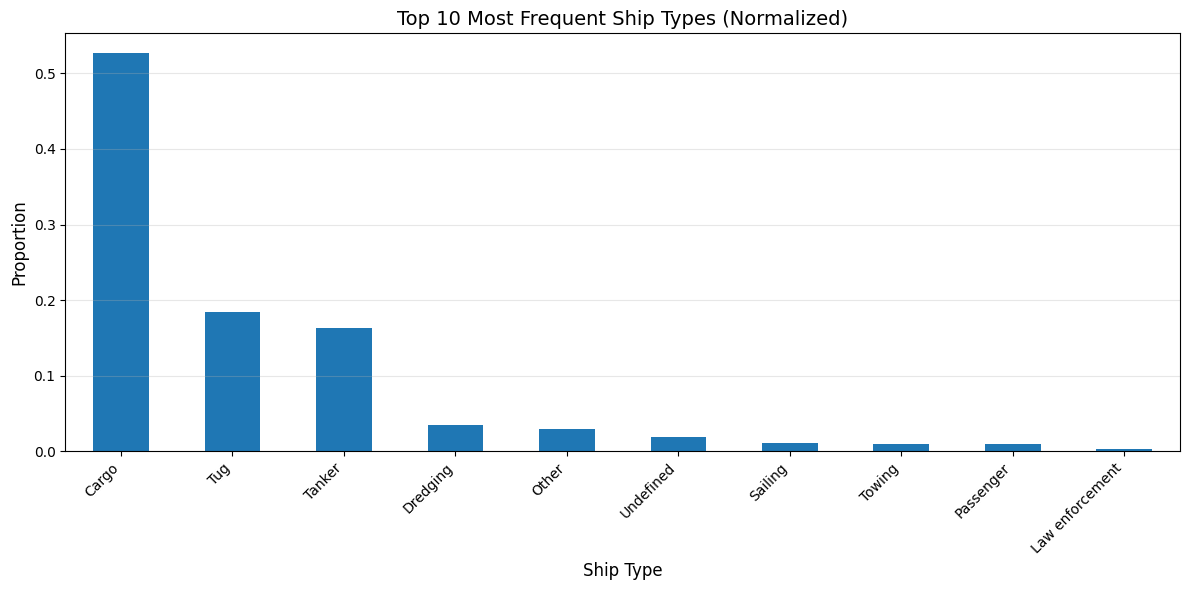

In [10]:
ship_types = df_clean['Ship type'] 
ship_types_norm = ship_types.value_counts(normalize=True)  # Count occurrences of each ship type

# Plot top 10 ship types as bar chart
top_10 = ship_types_norm.head(10)
plt.figure(figsize=(12, 6))
top_10.plot(kind='bar')
plt.xlabel('Ship Type', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.title('Top 10 Most Frequent Ship Types (Normalized)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

We see that the majority of the ships are cargo ships, followed by tankers and passenger ships. It will be considered in future work to feature engineer the data based on ship type to see if this improves the model performance. But for this project, we will not consider ship type as a feature.

## Feature Engineering

To make sure we consider features that can help the model perform better, we do a PCA analysis to see which features are the most important. 

We have already done a few feature engineering steps in the data preparation notebook, such as: 
- Finding cos & sin of COG to represent direction better.

In [11]:
train_df, val_df, test_df = dataloader.train_test_split(df=df_clean)


train_dataset = MaritimeDataset(train_df)
print("Feature Engineering: New columns in input data are")
train_dataset.feature_cols

Total segments: 22562
Train segments: 14940
Validation segments: 6360
Test segments: 6368
The 'no_port' ID is successfully set to: 20
Grouping data into sequences...
Created 14940 sequences.
Feature Engineering: New columns in input data are


['Latitude', 'Longitude', 'SOG', 'sin_COG', 'cos_COG', 'Log_RelativeTime']

We now do a PCA analysis on our train set to wich features are the most important. 

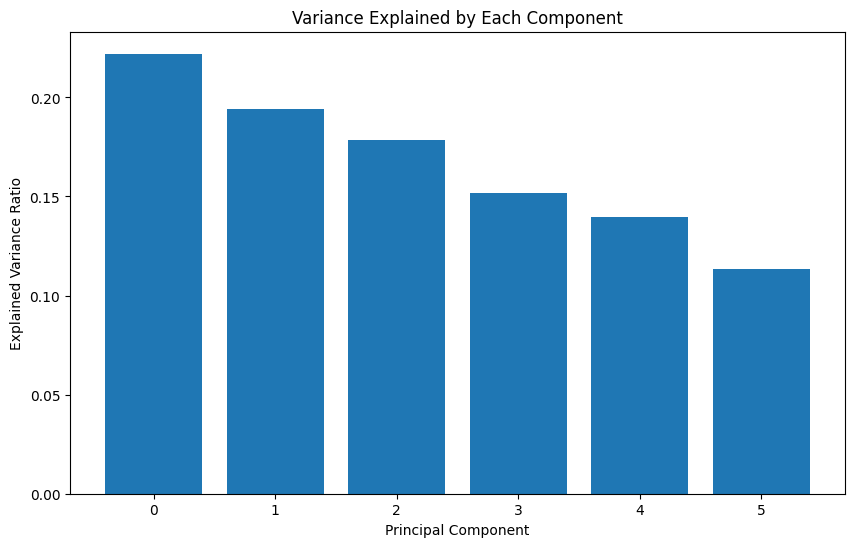

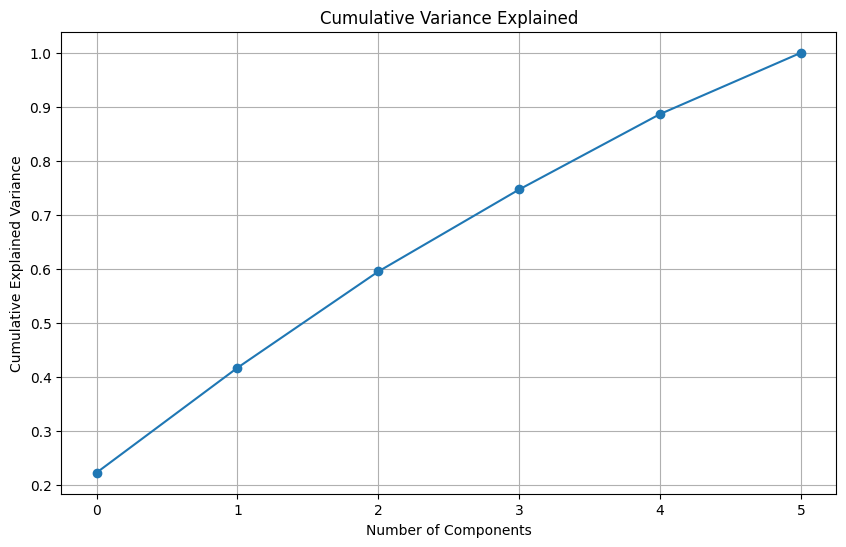

In [12]:

tensor_list = train_dataset.sequences

k = len(train_dataset.feature_cols) 

# Concatenate all tensors
all_data = torch.cat(tensor_list, dim=0).numpy()  # Shape: (total_timesteps, n_features)

# Fit PCA once on all data
scaler = StandardScaler()
pca = PCA(n_components=k)

all_data_scaled = scaler.fit_transform(all_data)

pca.fit(all_data_scaled)

# Explained variance ratio for each component
explained_var = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.bar(range(len(explained_var)), explained_var)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Variance Explained by Each Component')
plt.show()

# Cumulative explained variance
cumulative_var = np.cumsum(explained_var)
plt.figure(figsize=(10, 6))
plt.plot(cumulative_var, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance Explained')
plt.grid(True)
plt.show()


We see that no feature explain under 10% of the variance, which means that all features are important for the model and should be kept. The high variance per feature also indicates that there is low multicollinearity between the features, which is a good sign for the model performance. 

To check for multicollinearity between the features, we also plot a correlation matrix.

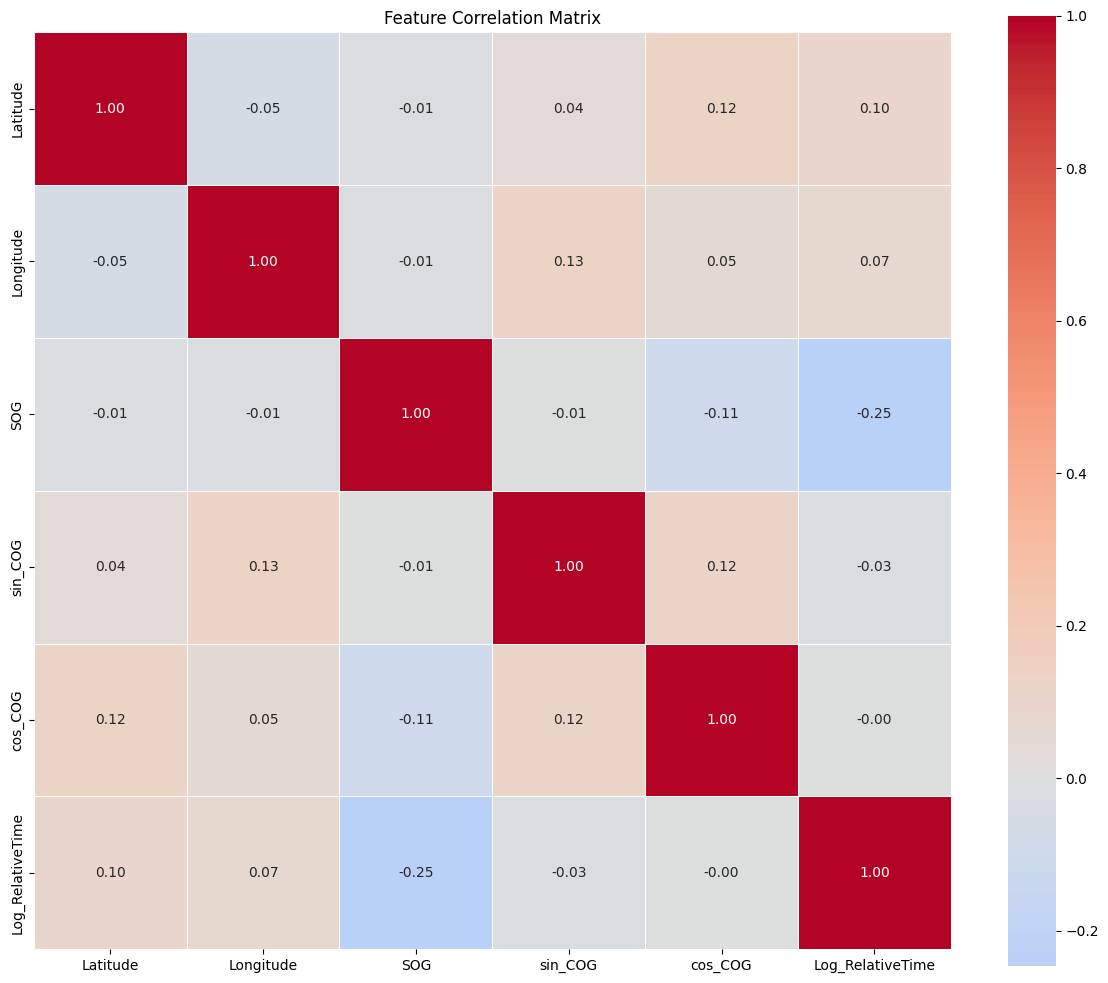

Highly correlated feature pairs:


In [13]:

corr_matrix = pd.DataFrame(all_data_scaled, columns=train_dataset.feature_cols).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


threshold = 0.8
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((i, j, corr_matrix.iloc[i, j]))

print("Highly correlated feature pairs:")
for i, j, corr in high_corr_pairs:
    print(f"Feature {i} & Feature {j}: {corr:.3f}")

We see that there a no highly correlated features (correlation > 0.8), which indicates low multicollinearity between the features. Therefore, the data for the model is clean and ready for training. 

# Training model

We now train (or load pretrained) models. 

For the full training details, see the **RNN.py** file.

In [14]:
models_to_train = ["LSTM_Transformer", "LSTM"] 

client = mlflow.MlflowClient() 

experiment = client.get_experiment_by_name(config["Experiment_Name"]) 

if (experiment is None and config["TRAIN_OWN_MODEL"]):
    experiment_id = client.create_experiment(config["Experiment_Name"])

elif (experiment is None and not config["TRAIN_OWN_MODEL"]):
    raise ValueError(f"Experiment '{config['Experiment_Name']}' does not exist. Cannot load pretrained model.")  

else:
    experiment_id = experiment.experiment_id 


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


Training own model

In [15]:
if (config["TRAIN_OWN_MODEL"]):

    test_len = len(test_df)
    val_len = len(val_df)
    train_len = len(train_df)
    total_len = test_len + val_len + train_len

    #setting hyperparams
    params = { "test_size": test_len / total_len,
        "val_size": val_len / total_len,
        "train_split": train_len / total_len,
        }

    hyperparams["general"] = {**hyperparams["general"], **params}

    mlflow.set_experiment(config["Experiment_Name"])

    for model_name in models_to_train:
        print(f"Training model: {model_name}")
        with mlflow.start_run(run_name=f"{model_name}-Run"):
            #Logging params for later analysis
            mlflow.log_params(hyperparams['general'])
            mlflow.log_params(hyperparams[model_name])
            mlflow.log_param("model_type", model_name) 

            
            trained_model = setup_and_train(train_df=train_df, 
                                            val_df=val_df, 
                                            test_df=test_df, 
                                            hyperparams=hyperparams, 
                                            model=model_name)
            
            #Logging the model 
            mlflow.pytorch.log_model(trained_model, f"{model_name}_Model")


        #clean up 
        del trained_model 
        gc.collect() 
        if (torch.cuda.is_available()):
            torch.cuda.empty_cache()

Load model and metrics

In [16]:
# Get all runs from the experiment

#To do: Delete manual sat experiment name
experiment = client.get_experiment_by_name(config["Experiment_Name"])
experiment_id = experiment.experiment_id 

all_runs = client.search_runs(
    experiment_ids=[experiment_id],
    order_by=["start_time DESC"]
)

print(f"Total runs found: {len(all_runs)}\n")


# Go through runs and check which have non-empty metrics
for i, run in enumerate(all_runs):
    run_id = run.info.run_id
    metrics = run.data.metrics
    
    if metrics:  # Check if metrics dict is not empty
        print(f"Run {i+1}: {run_id}")
        print(f"  Status: {run.info.status}")
        print(f"  Metrics: {metrics}")
        print()
    else:
        print(f"Run {i+1}: {run_id} - No metrics recorded")
        print()

Total runs found: 2

Run 1: b1a1d0a6cf604607b0f3bdfbf85b8a7c
  Status: FINISHED
  Metrics: {'acc_all_120min': 90.0, 'acc_all_15min': 89.62264150943396, 'acc_all_30min': 89.24528301886792, 'acc_all_60min': 89.43396226415095, 'acc_port_120min': 94.20289855072464, 'acc_port_15min': 98.30917874396135, 'acc_port_30min': 98.30917874396135, 'acc_port_60min': 98.79227053140097, 'learning_rate': 2.5e-05, 'train_loss': 0.06485018018150515, 'val_accuracy': 89.5754716981132, 'val_loss': 0.24703007195706567}

Run 2: 524a6c8e44b24a208b59c0101f7869d1
  Status: FINISHED
  Metrics: {'acc_all_120min': 89.30817610062893, 'acc_all_15min': 89.18238993710692, 'acc_all_30min': 89.49685534591195, 'acc_all_60min': 89.81132075471699, 'acc_port_120min': 90.57971014492753, 'acc_port_15min': 97.34299516908213, 'acc_port_30min': 97.34299516908213, 'acc_port_60min': 97.58454106280193, 'learning_rate': 1.25e-05, 'train_loss': 0.06793255767808944, 'val_accuracy': 89.4496855345912, 'val_loss': 0.2806164281747401}



We load the metrics

In [17]:
def get_run_metrics_history(client, run_id, metric_names=None):

    run = client.get_run(run_id)
    
    # Get all metric keys if not specified
    if metric_names is None:
        metric_names = list(run.data.metrics.keys())
    
    metrics_history = {}
    
    for metric_name in metric_names:
        history = client.get_metric_history(run_id, metric_name)

        metrics_history[metric_name] = [
            (m.step, m.value, m.timestamp) for m in history
        ]
    
    return metrics_history


# Example usage:
# Assuming you have a run_id from your search
run_id = all_runs[1].info.run_id
metrics_history = get_run_metrics_history(client, run_id)

# Access specific metric across epochs
train_loss_history = metrics_history.get('train_loss', [])
for step, value, timestamp in train_loss_history:
    print(f"Epoch {step}: Loss = {value:.4f}")
# Or get specific metrics only
# specific_metrics = get_run_metrics_history(client, run_id, ['train_loss', 'val_accuracy'])

Epoch 1: Loss = 0.9810
Epoch 1: Loss = 0.9810
Epoch 2: Loss = 0.3966
Epoch 2: Loss = 0.3966
Epoch 3: Loss = 0.2781
Epoch 3: Loss = 0.2781
Epoch 4: Loss = 0.2330
Epoch 4: Loss = 0.2330
Epoch 5: Loss = 0.2160
Epoch 5: Loss = 0.2160
Epoch 6: Loss = 0.1973
Epoch 6: Loss = 0.1973
Epoch 7: Loss = 0.1892
Epoch 7: Loss = 0.1892
Epoch 8: Loss = 0.2005
Epoch 8: Loss = 0.2005
Epoch 9: Loss = 0.1913
Epoch 9: Loss = 0.1913
Epoch 10: Loss = 0.2049
Epoch 10: Loss = 0.2049
Epoch 11: Loss = 0.1725
Epoch 11: Loss = 0.1725
Epoch 12: Loss = 0.1722
Epoch 12: Loss = 0.1722
Epoch 13: Loss = 0.2211
Epoch 13: Loss = 0.2211
Epoch 14: Loss = 0.1858
Epoch 14: Loss = 0.1858
Epoch 15: Loss = 0.1673
Epoch 15: Loss = 0.1673
Epoch 16: Loss = 0.1378
Epoch 16: Loss = 0.1378
Epoch 17: Loss = 0.1618
Epoch 17: Loss = 0.1618
Epoch 18: Loss = 0.0944
Epoch 18: Loss = 0.0944
Epoch 19: Loss = 0.0933
Epoch 19: Loss = 0.0933
Epoch 20: Loss = 0.0911
Epoch 20: Loss = 0.0911
Epoch 21: Loss = 0.0885
Epoch 21: Loss = 0.0885
Epoch 22: 

# Results

We plot metrics

<Axes: title={'center': 'Metrics Comparison Across Runs'}, xlabel='Epoch', ylabel='Metric Value val_loss'>

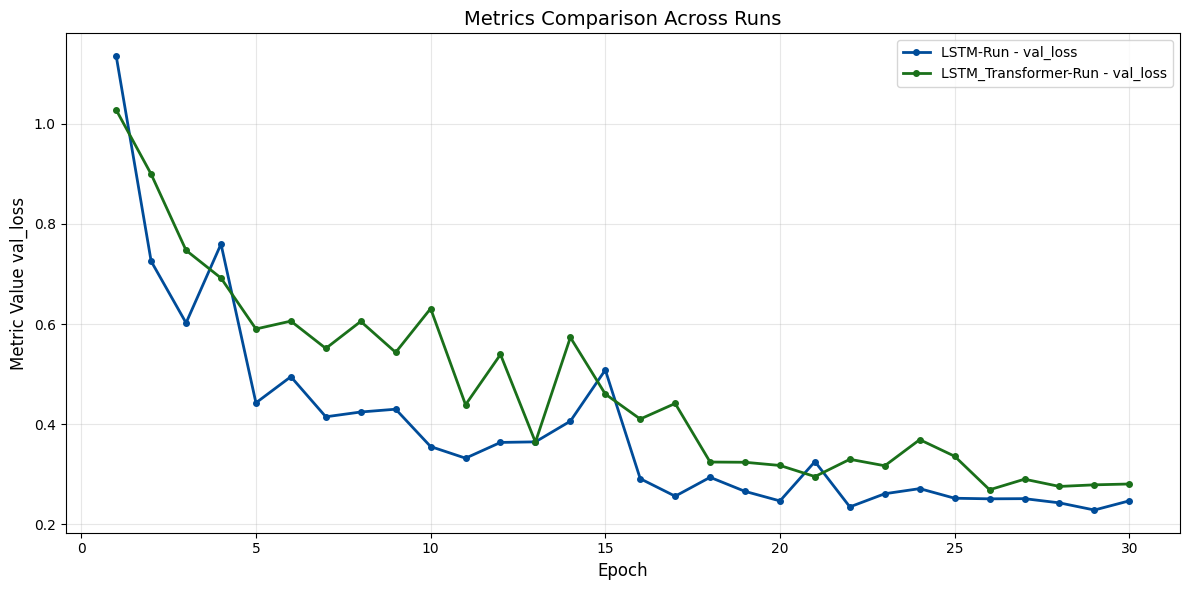

In [ ]:
def plot_runs_comparison(client, run_ids, metric_names=None):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for run_id in run_ids:
        run = client.get_run(run_id)
        run_name = run.info.run_name or run_id[:8]
        
        metrics_history = get_run_metrics_history(client, run_id, metric_names)
        
        for metric_name, history in metrics_history.items():
            if history:
                steps, values, _ = zip(*history)
                ax.plot(steps, values, marker='o', label=f'{run_name} - {metric_name}', linewidth=2, markersize=4)
    if (not metric_names): 
        metric_names = []

    names = ' '.join(metric_names)  # 'hello world test'


    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel(f'Metric Value {names}', fontsize=12)
    ax.set_title('Metrics Comparison Across Runs', fontsize=14)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    # plt.show()
    return ax


# Example usage:
run_id_1 = all_runs[0].info.run_id
run_id_2 = all_runs[1].info.run_id
plot_runs_comparison(client, [run_id_1, run_id_2], metric_names=['val_loss'])

Text(117.09722222222221, 0.5, 'Accuracy')

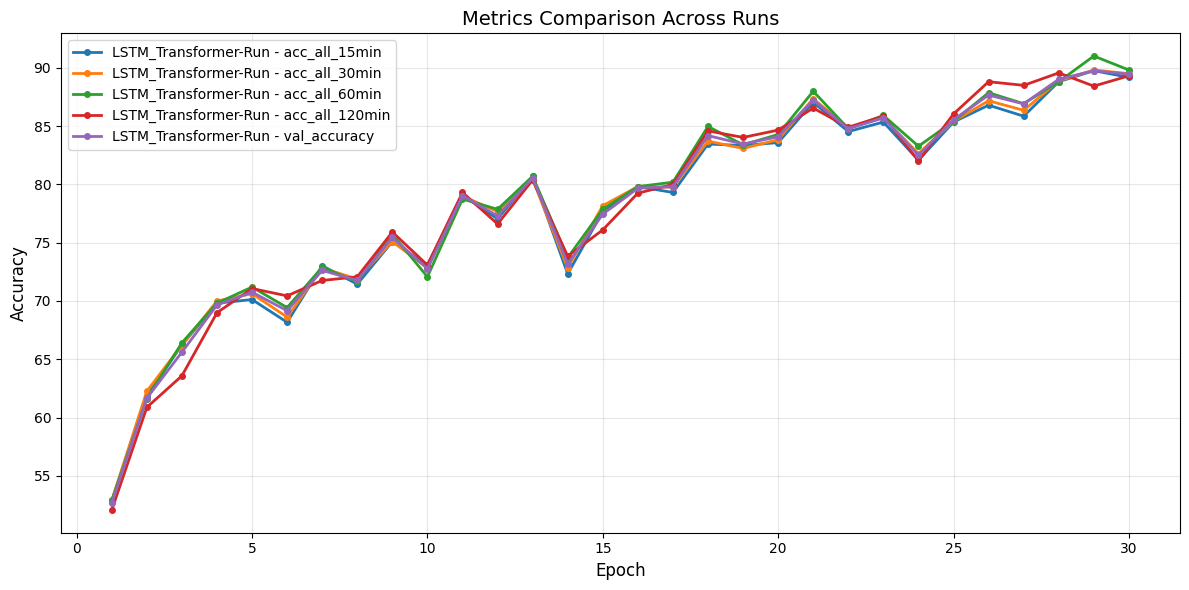

In [19]:
ax = plot_runs_comparison(client, [run_id_1], metric_names=['acc_all_15min','acc_all_30min','acc_all_60min', 'acc_all_120min','val_accuracy'])
ax.set_ylabel('Accuracy', fontsize=12)

Text(108.34722222222221, 0.5, 'Accuracy')

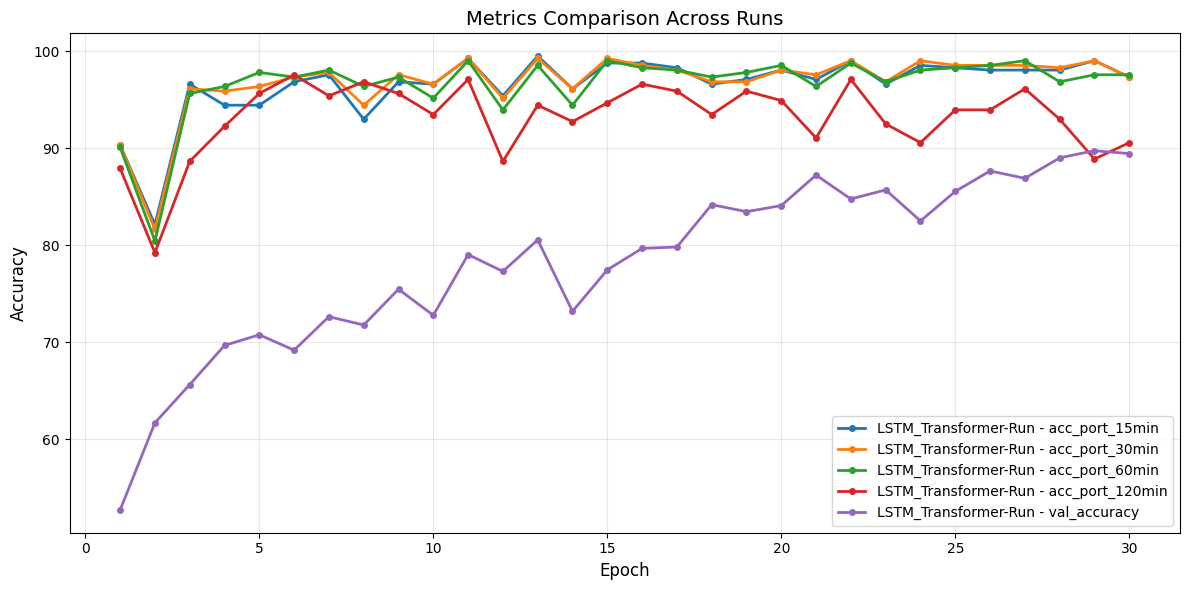

In [20]:
ax = plot_runs_comparison(client, [run_id_1], metric_names=['acc_port_15min','acc_port_30min','acc_port_60min', 'acc_port_120min','val_accuracy'])
ax.set_ylabel('Accuracy', fontsize=12)

Text(112.72222222222221, 0.5, 'Loss')

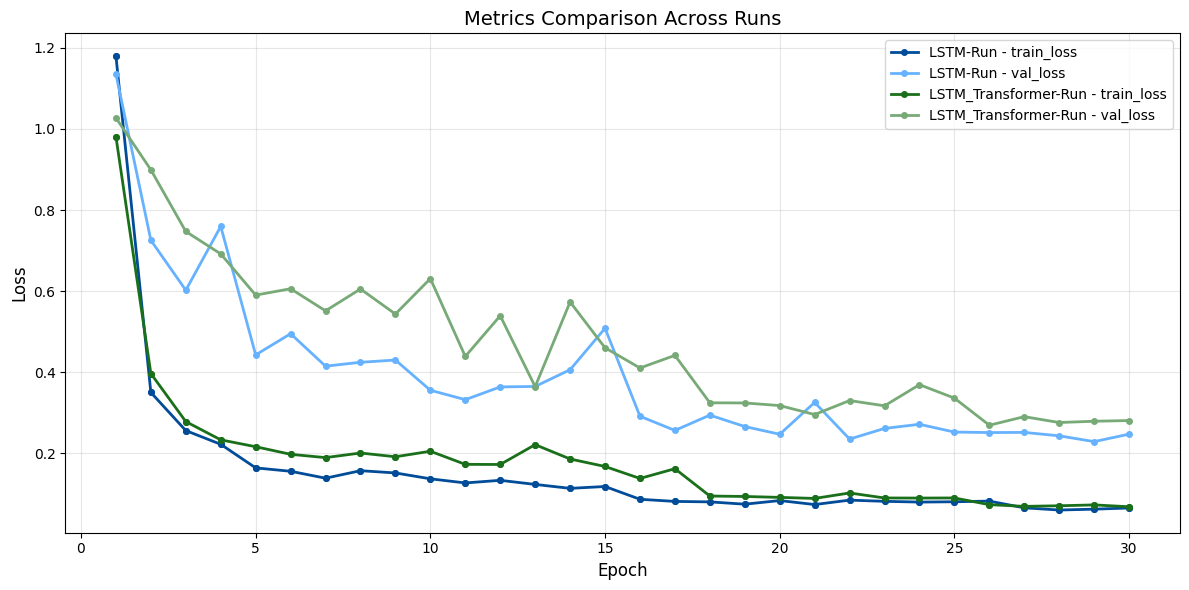

In [42]:
ax = plot_runs_comparison(client, [run_id_1, run_id_2], metric_names=['train_loss','val_loss'])
ax.set_ylabel('Loss', fontsize=12)

### Statistal evalution

First loading model back in and running inference on test set

In [22]:
test_dataset = MaritimeDataset(test_df, port_encoder=train_dataset.port_encoder,feature_scaler=train_dataset.feature_scaler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
StatEval = StatEvalAIS(experiment_id=experiment_id, test_loader=test_loader, encoder=train_dataset.port_encoder, feature_scaler=train_dataset.feature_scaler)
StatEval.load_models()
StatEval.evaluate_models()

The 'no_port' ID is successfully set to: 20
Grouping data into sequences...


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Created 6368 sequences.


Computing confidence intervals by bootstrapping mean for both models and horizons. Also for whole dataset and when port=!no_port

In [23]:
eval_df = StatEval.eval_df
unique_horizons = sorted(eval_df['horizons'].unique())
models = ['LSTM', 'LSTM Transformer']

model_tables = {}

for model in models:
    table = []
    overall_lower, overall_mean, overall_upper = StatEval.confidence_intervals_bootstrap(model, eval_df)
    for horizon in unique_horizons:
        df_horizon = eval_df[eval_df['horizons'] == horizon]
        df_horizon_ports = df_horizon[df_horizon['targets']<20]
        acc_lower, acc_mean, acc_upper = StatEval.confidence_intervals_bootstrap(model, df_horizon)
        lower, mean, upper = StatEval.confidence_intervals_bootstrap(model, df_horizon_ports)
        table.append({
            "Horizon (min)": horizon,
            "Accuracy": f'{acc_mean:.3f} ({acc_lower:.3f}, {acc_upper:.3f})',
            "Accuracy (Any port recall)": f'{mean:.3f} ({lower:.3f}, {upper:.3f})',
        })
    table.append({
        "Horizon (min)": "Overall",
        "Accuracy": f'{overall_mean:.3f} ({overall_lower:.3f}, {overall_upper:.3f})'})
    model_tables[model] = pd.DataFrame(table)


In [24]:
model_tables['LSTM']

,Horizon (min),Accuracy,Accuracy (Any port recall)
0,15,"0.894 (0.879, 0.909)","0.990 (0.979, 0.997)"
1,30,"0.897 (0.882, 0.911)","0.990 (0.979, 0.997)"
2,60,"0.896 (0.881, 0.911)","0.990 (0.979, 0.997)"
3,120,"0.911 (0.897, 0.925)","0.951 (0.930, 0.972)"
4,Overall,"0.900 (0.892, 0.907)",NaN


In [25]:
model_tables['LSTM Transformer']

,Horizon (min),Accuracy,Accuracy (Any port recall)
0,15,"0.888 (0.872, 0.903)","0.977 (0.961, 0.990)"
1,30,"0.888 (0.872, 0.903)","0.974 (0.956, 0.990)"
2,60,"0.893 (0.878, 0.908)","0.961 (0.940, 0.979)"
3,120,"0.893 (0.878, 0.908)","0.899 (0.868, 0.927)"
4,Overall,"0.890 (0.883, 0.898)",NaN


In [46]:
unique_horizons = sorted(eval_df['horizons'].unique())
unique_ports = sorted(eval_df['targets'].unique())
models = ['LSTM', 'LSTM Transformer']
port_encoder = train_dataset.port_encoder

model_tables = {}

for model in models:
    print(f"Processing table for model: {model}...")
    rows_list = []
    
    for horizon in unique_horizons:
        df_horizon = eval_df[eval_df['horizons'] == horizon]
        row_data = {'Horizon': horizon}
        
        # --- A. Overall Accuracy ---
        low, mean, high = StatEval.confidence_intervals_bootstrap(model, df_horizon)
        # using the standard asymmetric format
        row_data['Overall Accuracy'] = f"{mean:.3f} ({low:.3f}-{high:.3f})"
        
        # --- B. Per-Port Metrics ---
        for port_id in unique_ports:
            # Decode Name
            try:
                raw_name = port_encoder.inverse_transform([port_id])[0]
                port_name = str(raw_name).replace("_", " ") # Clean for LaTeX
            except:
                port_name = f"Port {port_id}"
            
            # 1. Recall (Target == Port)
            df_recall = df_horizon[df_horizon['targets'] == port_id]
            # Check if we actually have data for this port to avoid errors
            if len(df_recall) > 1:
                r_low, r_mean, r_high = StatEval.confidence_intervals_bootstrap(model, df_recall)
                row_data[f'Recall ({port_name})'] = f"{r_mean:.3f} ({r_low:.3f}-{r_high:.3f})"
            else:
                row_data[f'Recall ({port_name})'] = "N/A"

            # 2. Precision (Prediction == Port)
            df_precision = df_horizon[df_horizon[model] == port_id]
            if len(df_precision) > 1:
                p_low, p_mean, p_high = StatEval.confidence_intervals_bootstrap(model, df_precision)
                row_data[f'Precision ({port_name})'] = f"{p_mean:.3f} ({p_low:.3f}-{p_high:.3f})"
            else:
                row_data[f'Precision ({port_name})'] = "N/A"
            
        rows_list.append(row_data)
    
    # Store and Format
    model_df = pd.DataFrame(rows_list)
    model_df.set_index('Horizon', inplace=True)
    model_tables[model] = model_df

Processing table for model: LSTM...
Processing table for model: LSTM Transformer...


In [47]:
model_tables['LSTM'].T

Horizon,15,30,60,120
Overall Accuracy,0.894 (0.879-0.909),0.897 (0.882-0.911),0.896 (0.881-0.911),0.911 (0.897-0.925)
Recall (DECKL),0.863 (0.727-1.000),0.863 (0.727-1.000),0.864 (0.727-1.000),0.819 (0.636-0.955)
Precision (DECKL),1.000 (1.000-1.000),1.000 (1.000-1.000),1.000 (1.000-1.000),0.899 (0.750-1.000)
Recall (DEHTU),1.000 (1.000-1.000),1.000 (1.000-1.000),1.000 (1.000-1.000),0.917 (0.806-1.000)
Precision (DEHTU),0.493 (0.384-0.603),0.493 (0.384-0.603),0.501 (0.389-0.611),0.622 (0.491-0.755)
Recall (DERSK),1.000 (1.000-1.000),1.000 (1.000-1.000),1.000 (1.000-1.000),0.955 (0.889-1.000)
Precision (DERSK),0.542 (0.434-0.651),0.570 (0.456-0.684),0.584 (0.468-0.688),0.605 (0.493-0.718)
Recall (DKAAL),1.000 (1.000-1.000),1.000 (1.000-1.000),1.000 (1.000-1.000),1.000 (1.000-1.000)
Precision (DKAAL),0.688 (0.438-0.875),0.688 (0.438-0.875),0.688 (0.438-0.875),0.688 (0.438-0.875)
Recall (DKAAR),1.000 (1.000-1.000),1.000 (1.000-1.000),1.000 (1.000-1.000),1.000 (1.000-1.000)


In [48]:
model_tables['LSTM Transformer'].T

Horizon,15,30,60,120
Overall Accuracy,0.888 (0.872-0.903),0.888 (0.872-0.903),0.893 (0.878-0.908),0.893 (0.878-0.908)
Recall (DECKL),0.909 (0.773-1.000),0.909 (0.773-1.000),0.909 (0.773-1.000),0.818 (0.636-0.955)
Precision (DECKL),0.834 (0.667-0.958),0.800 (0.640-0.960),0.833 (0.667-0.958),0.693 (0.500-0.846)
Recall (DEHTU),0.944 (0.861-1.000),0.916 (0.806-1.000),0.944 (0.861-1.000),0.778 (0.639-0.917)
Precision (DEHTU),0.486 (0.371-0.600),0.493 (0.373-0.612),0.540 (0.413-0.667),0.651 (0.512-0.791)
Recall (DERSK),1.000 (1.000-1.000),1.000 (1.000-1.000),1.000 (1.000-1.000),0.888 (0.800-0.978)
Precision (DERSK),0.556 (0.444-0.667),0.562 (0.450-0.675),0.585 (0.468-0.688),0.597 (0.478-0.716)
Recall (DKAAL),1.000 (1.000-1.000),1.000 (1.000-1.000),1.000 (1.000-1.000),0.909 (0.727-1.000)
Precision (DKAAL),0.581 (0.368-0.789),0.581 (0.368-0.789),0.552 (0.350-0.750),0.556 (0.333-0.778)
Recall (DKAAR),1.000 (1.000-1.000),1.000 (1.000-1.000),1.000 (1.000-1.000),1.000 (1.000-1.000)


Doing a paired t-test for 

In [29]:
alfa = 0.05
bonferroni_alfa = alfa / (len(unique_horizons)*2)
for horizon in unique_horizons:
    print('')
    df_horizon = eval_df[eval_df['horizons'] == horizon]
    t_stat, p_value, lstm_mean, lstm_transformer_mean = StatEval.paired_t_test(df_horizon)
    print(f"LSTM Mean Accuracy: {lstm_mean:.4f}, LSTM Transformer Mean Accuracy: {lstm_transformer_mean:.4f}")
    print(f"Horizon: {horizon} - Paired t-test between LSTM and LSTM Transformer: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
    print(f"Best model at horizon {horizon} using alfa {alfa} and bonferroni corrected alfa {bonferroni_alfa}: ")
    if p_value < bonferroni_alfa:
        if lstm_mean > lstm_transformer_mean:
            print("LSTM")
        else:
            print("LSTM Transformer")
    else:
        print("No significant difference")


LSTM Mean Accuracy: 0.8938, LSTM Transformer Mean Accuracy: 0.8876
Horizon: 15 - Paired t-test between LSTM and LSTM Transformer: t-statistic = 1.3134, p-value = 0.1892
Best model at horizon 15 using alfa 0.05 and bonferroni corrected alfa 0.00625: 
No significant difference

LSTM Mean Accuracy: 0.8970, LSTM Transformer Mean Accuracy: 0.8876
Horizon: 30 - Paired t-test between LSTM and LSTM Transformer: t-statistic = 1.9886, p-value = 0.0469
Best model at horizon 30 using alfa 0.05 and bonferroni corrected alfa 0.00625: 
No significant difference

LSTM Mean Accuracy: 0.8964, LSTM Transformer Mean Accuracy: 0.8932
Horizon: 60 - Paired t-test between LSTM and LSTM Transformer: t-statistic = 0.6201, p-value = 0.5353
Best model at horizon 60 using alfa 0.05 and bonferroni corrected alfa 0.00625: 
No significant difference

LSTM Mean Accuracy: 0.9114, LSTM Transformer Mean Accuracy: 0.8932
Horizon: 120 - Paired t-test between LSTM and LSTM Transformer: t-statistic = 3.0479, p-value = 0.002